In [1]:
from Systems import UnbalancedDisc
from Systems import NoisyUnbalancedDisc
from Systems import DiscreteUnbalancedDisc
import deepSI
from matplotlib import pyplot as plt
import numpy as np
#import autograd
import torch
import time
from torch import nn
#import quadprog as qp
import qpsolvers as qp

In [2]:
system = NoisyUnbalancedDisc(dt=0.1, sigma_n=[0, 0])

class I_encoder(deepSI.fit_systems.SS_encoder):
    def __init__(self, nx = 2, na=2, nb=2, feedthrough=False) -> None:
        super().__init__(nx=nx, na=na, nb=nb, feedthrough=feedthrough)

    def init_nets(self, nu, ny): # a bit weird
        ny = ny if ny is not None else 1
        nu = nu if nu is not None else 1
        self.encoder = self.e_net(self.nb*nu+self.na*ny, self.nx, n_nodes_per_layer=self.e_n_nodes_per_layer, n_hidden_layers=self.e_n_hidden_layers, activation=self.e_activation)
        self.fn =      self.f_net(self.nx+nu,            self.nx, n_nodes_per_layer=self.f_n_nodes_per_layer, n_hidden_layers=self.f_n_hidden_layers, activation=self.f_activation)
        hn_in = self.nx + nu if self.feedthrough else self.nx
        self.hn =      nn.Identity(hn_in)#

I_enc = deepSI.load_system("systems/UnbalancedDisk_dt01_e100_SNR_100")

In [3]:
# function that converts torch nn to casadi expression
from casadi import *

def CasADiHn(ss_enc, x):
    n_hidden_layers = ss_enc.h_n_hidden_layers

    params = {}
    for name, param in ss_enc.hn.named_parameters():
        params[name] = param.detach().numpy()
    params_list = list(params.values())

    temp_nn = x
    for i in range(n_hidden_layers):
        W_NL = params_list[2+i*2]
        b_NL = params_list[3+i*2]
        temp_nn = mtimes(W_NL, temp_nn)+b_NL
        temp_nn = tanh(temp_nn)
    W_NL = params_list[2+n_hidden_layers*2]
    b_NL = params_list[3+n_hidden_layers*2]
    nn_NL = mtimes(W_NL, temp_nn)+b_NL

    W_Lin = params_list[0]
    b_Lin = params_list[1]
    nn_Lin = mtimes(W_Lin,x) + b_Lin

    return nn_NL + nn_Lin

def CasADiFn(ss_enc, x, u):
    n_hidden_layers = ss_enc.f_n_hidden_layers

    params = {}
    for name, param in ss_enc.fn.named_parameters():
        params[name] = param.detach().numpy()
    params_list = list(params.values())
    
    xu = vertcat(x,u)

    temp_nn = xu
    for i in range(n_hidden_layers):
        W_NL = params_list[2+i*2]
        b_NL = params_list[3+i*2]
        temp_nn = mtimes(W_NL, temp_nn)+b_NL
        temp_nn = tanh(temp_nn)
    W_NL = params_list[2+n_hidden_layers*2]
    b_NL = params_list[3+n_hidden_layers*2]
    nn_NL = mtimes(W_NL, temp_nn)+b_NL

    W_Lin = params_list[0]
    b_Lin = params_list[1]
    nn_Lin = mtimes(W_Lin,xu) + b_Lin

    return nn_NL + nn_Lin

In [37]:
# declared sym variables
x = MX.sym("x",I_enc.nx,1)
nu = I_enc.nu if I_enc.nu is not None else 1
u = MX.sym("u",nu,1)

# convert torch nn to casadi function
rhs = CasADiFn(I_enc, x, u)
f = Function('f', [x, u], [rhs])

#y_rhs = CasADiHn(I_enc, x)
#h = Function('h', [x], [y_rhs])

# apply correction to casadi function such that fc(0) = 0
correction_f = f([0,0], 0)
rhs_c = rhs - correction_f
#correction_h = h([0,0])
#y_rhs_c = y_rhs - correction_h
f_c = Function('f_c', [x, u], [rhs_c])
#h_c = Function('h_c', [x], [y_rhs_c])

In [38]:
# Box constraints
x_min = [-10, -10]
x_max = [10, 10]
u_min = -4
u_max = 4

# Initial and final values
x0 = [0,0]
x_ref = [0.001, 1.0]
u_ref = 0

# Weight matrices for the cost function
Q = np.array([[1,0],[0,100]])
R = 1

# MPC parameters
dt = 0.1
Nc = 20
Nsim = 50
#dlam = 0.01
stages = 100

In [39]:
L = np.zeros([3*stages,1])
lam = 0
dlam = 1.0/stages

for i in range(stages):
    L[i] = lam
    L[i+stages] = lam + dlam/2
    L[i+2*stages] = lam + dlam

    lam = lam + dlam

n_states = np.shape(x)[0]
nx = n_states
n_controls = np.shape(u)[0]
nu = n_controls

In [40]:
Jfx = Function("Jfx", [x, u], [jacobian(rhs_c,x)])
Jfu = Function("Jfu", [x, u], [jacobian(rhs_c,u)])

In [41]:
# def par_lpv_int(x,nx,u,nu,Jfx,Jfu,dlam,stages,L):
#     # FUNCTION LPV_INT
#     # RK4 integrator with chosen resolution and internal stages
#     # used to get A,B matrices symbolically to be used at gridpoints
    
#     A = np.zeros([nx,nx])
#     B = np.zeros([nx,nu])

#     Lx = np.kron(L,x)
#     #Lx = reshape(kron(L,x), (2,stages*3)).T
#     Lu = L*u

#     Fx = Jfx.map(stages)
#     kx = Fx(Lx.T, Lu.T)
#     Fu = Jfu.map(stages)
#     ku = Fu(Lx.T, Lu.T)

#     A = np.zeros((2,2))
#     A[:,0] = reshape(sum2(kx[:,0:stages*2:2]), (1,2)) # k1
#     A[:,1] = reshape(sum2(kx[:,1:stages*2:2]), (1,2)) # k1
#     A[:,0] = A[:,0] + 4*reshape(sum2(kx[:,stages*2:stages*4:2]), (1,2)) # k2
#     A[:,1] = A[:,1] + 4*reshape(sum2(kx[:,stages*2+1:stages*4:2]), (1,2)) # k2
#     A[:,0] = A[:,0] + reshape(sum2(kx[:,stages*4:stages*6:2]), (1,2)) # k4
#     A[:,1] = A[:,1] + reshape(sum2(kx[:,stages*4+1:stages*6:2]), (1,2)) # k4
#     A = 1/6*dlam*A

#     B = np.zeros((2,1))
#     B[:,0] = reshape(sum2(ku[:,0:stages:1]), (1,2)) # k1
#     B[:,0] = B[:,0] + 4*reshape(sum2(ku[:,stages:2*stages:1]), (1,2)) # k2
#     B[:,0] = B[:,0] + reshape(sum2(ku[:,2*stages:3*stages:1]), (1,2)) # k4
#     B = 1/6*dlam*B
            
#     return A, B

In [42]:
def lpv_int(x,nx,u,nu,Jfx,Jfu,dlam,stages):
    # FUNCTION LPV_INT
    # RK4 integrator with chosen resolution and internal stages
    # used to get A,B matrices symbolically to be used at gridpoints
    
    A = np.zeros([nx,nx])
    B = np.zeros([nx,nu])
    
    lam = 0

    for i in np.arange(stages):
        k1 = Jfx(lam*x,lam*u)
        j1 = Jfu(lam*x,lam*u)

        k2 = Jfx((lam+dlam/2)*x,(lam+dlam/2)*u)
        j2 = Jfu((lam+dlam/2)*x,(lam+dlam/2)*u)

        k4 = Jfx((lam+dlam)*x,(lam+dlam)*u)
        j4 = Jfu((lam+dlam)*x,(lam+dlam)*u)

        A = A + 1/6*dlam*(k1 + 4*k2 + k4)
        B = B + 1/6*dlam*(j1 + 4*j2 + j4)
        lam = lam + dlam
            
    return A,B

In [43]:
[A, B] = lpv_int(x,2,u,1,Jfx,Jfu,dlam,stages)
get_A = Function("get_A",[x,u],[A])
get_B = Function("get_B",[x,u],[B])

In [44]:
# xt = np.tile(x0, Nc)
# ut = np.zeros(Nc*nu)
Get_A = get_A.map(Nc, "thread", 32)
Get_B = get_B.map(Nc, "thread", 32)

In [45]:
# iterations = 100
# list_A = np.zeros([Nc*nx, nx])
# list_B = np.zeros([Nc*nx, nu])

# start_time = time.time()
# for j in range(iterations):
#     for i in np.arange(Nc):
#         list_A[(n_states*i):(n_states*i+n_states),:] = get_A(xt[i*nx:(i+1)*nx],ut[i*nu:(i+1)*nu])
#         list_B[(n_states*i):(n_states*i+n_states),:] = get_B(xt[i*nx:(i+1)*nx],ut[i*nu:(i+1)*nu])

# print(time.time() - start_time)

In [46]:
# iterations = 100
# list_A1 = np.zeros([Nc*nx, nx])
# list_B1 = np.zeros([Nc*nx, nu])
# start_time = time.time()

# for j in range(iterations):
#     list_A1 = (Get_A(xt.reshape(2,Nc),ut))
#     list_B1 = (Get_B(xt.reshape(2,Nc),ut))

# print(time.time() - start_time)

In [47]:
import itertools

def getPhi(list_A, Nc, nx, nu):
    Phi = np.zeros([nx*Nc, nx])
    for i in range(Nc):
        temp = np.eye(nx)
        for j in range(i,-1,-1):
            temp = np.matmul(temp, list_A[(nx*j):(nx*j+nx),:])
        Phi[i*nx:(i+1)*nx, :] = temp
    return Phi

def getGamma(list_A, list_B, Nc, nx, nu):
    Gamma = np.zeros([nx*Nc, nu*Nc])
    for i in range(Nc):
        for j in range(0,i+1):
            temp = np.eye(nx)
            for l in range(i-j,-1,-1):
                if l == 0:
                    temp = np.matmul(temp, list_B[(nx*j):(nx*j+nx),:])
                else:
                    temp = np.matmul(temp, list_A[(nx*l):(nx*l+nx),:])
            Gamma[i*nx:nx*(i+1),j*nu:(j+1)*nu] = temp
    return Gamma

def getPsi(Nc, R):
    return np.kron(np.eye(Nc), R)

def getOmega(Nc, Q):
    return np.kron(np.eye(Nc), Q)

def getDEMc(x_min, x_max, u_min, u_max, Nc, nx, nu):
    bi = np.array([list(itertools.chain([-u_min, u_max], [x*-1 for x in x_min],  x_max))])
    bN = np.array([list(itertools.chain([x*-1 for x in x_min],  x_max))])
    c = np.hstack((np.tile(bi, Nc), bN)).T

    In = np.eye(nx)
    Im = np.eye(nu)
    Zn = np.zeros((nu,nx))
    Zm = np.zeros((nx,nu))

    Mi = np.vstack((Zn, Zn, -In, In))
    Mn = np.vstack((-In, In))
    M = (np.zeros((Nc*2*(nx+nu)+2*nx, Nc*nx)))
    M[Nc*2*(nx+nu):,(Nc-1)*nx:] = Mn
    M[2*(nx+nu):Nc*2*(nx+nu),:(Nc-1)*nx] = np.kron(np.eye(Nc-1), Mi)

    Ei = np.vstack((-Im, Im, Zm, Zm))
    E = np.vstack((np.kron(np.eye(Nc), Ei), np.zeros((nx*2, Nc*nu))))

    D = np.zeros((Nc*2*(nx+nu)+2*nx, nx))
    D[:2*(nx+nu),:] = Mi

    return D, E, M, c

In [48]:
# list_A = np.ones([Nc*nx, nx])
# list_B = np.ones([Nc*nx, nu])
# Phi = getPhi(list_A, Nc, nx, nu)
# Gamma = getGamma(list_A, list_B, Nc, nx, nu)

# D, E, M, B = getDEMc(x_min, x_max, u_min, u_max, Nc, nx, nu)
# L = (M@Gamma) + E
# W = -D - (M@Phi)
# W.shape, L.shape

In [49]:
Nsim = 50
# logging list
x0 = np.array([0.0,0.5])
u_log = np.zeros(Nsim*n_controls)
x_log = np.zeros((Nsim+1)*n_states)
x_log[:nx] = x0
components_times = np.zeros(3) # getAB, solve, denorm and sim
component_start = 0
t = np.zeros(Nsim)
t0 = 0
comp_t_log = np.zeros(Nsim)
start = time.time()
lpv_counter = np.zeros(Nsim,int)

# normalize reference list
norm = I_enc.norm
#reference_list_normalized = (reference_list - norm.y0[1])/norm.ystd[1]
x0_norm = (x0 - norm.y0)/norm.ystd

# set initial values for x
x = np.tile(x0_norm, Nc)
u = np.zeros(Nc*nu)

list_A = np.zeros([Nc*nx, nx])
list_B = np.zeros([Nc*nx, nu])
Psi = getPsi(Nc, R)
Omega = getPsi(Nc, Q)
D, E, M, c = getDEMc(x_min, x_max, u_min, u_max, Nc, nx, nu)

for mpciter in range(Nsim):
    start_time_iter = time.time()
    
    while True:
        # for i in np.arange(Nc):
        #     list_A[(n_states*i):(n_states*i+n_states),:] = get_A(x[i*nx:(i+1)*nx],u[i*nu:(i+1)*nu])
        #     list_B[(n_states*i):(n_states*i+n_states),:] = get_B(x[i*nx:(i+1)*nx],u[i*nu:(i+1)*nu])
        list_A = reshape(Get_A(x.reshape(2,Nc),u), (Nc*nx, nx))
        list_B = reshape(Get_B(x.reshape(2,Nc),u), (Nc*nx, nu))
        

        Phi = getPhi(list_A, Nc, nx, nu)
        Gamma = getGamma(list_A, list_B, Nc, nx, nu)
        G = 2*(Psi+(Gamma.T@Omega@Gamma))
        F = 2*(Gamma.T@Omega@Phi)
        L = (M@Gamma) + E
        W = -D - (M@Phi)

        u_old = u
        #x_ss = x[:2] - [0, 1]
        #u = -np.linalg.inv(G)@F@x[:2]
        qp.solve_qp(G,F@x[:2],L,(W@np.array([0,0])) + c[:,0], solver="quadprog")
         
        x[nx:Nc*nx] = ((Phi@x[:2]) + Gamma@u)[:(Nc-1)*nx]
        
        lpv_counter[mpciter] += 1
        if (lpv_counter[mpciter] >= 5) or (np.linalg.norm(u-u_old) < 1e-5):
            break

    print("MPC iteration: ", mpciter+1)
    print("LPV counter: ", lpv_counter[mpciter])
    
    t[mpciter] = t0
    t0 = t0 + dt
    
    # denormalize x and u
    x_denormalized = norm.ystd*x0_norm + norm.y0
    u_denormalized = norm.ustd*u[0] + norm.u0

    # make system step and normalize
    x_denormalized = system.f(x_denormalized, u_denormalized)
    x_measured = system.h(x_denormalized, u_denormalized)
    x0_norm = (x_measured - norm.y0)/norm.ystd

    x_log[(mpciter+1)*nx:(mpciter+2)*nx] = x_measured
    u_log[mpciter] = u_denormalized
    
    x = np.hstack((x[nx:(Nc+1)*nx],x[-2:]))
    x[:nx] = x0_norm
    u = np.hstack((u[nx:Nc*nx],u[-2:]))

    # finished mpc time measurement
    end_time_iter = time.time()
    comp_t_log[mpciter] = end_time_iter - start_time_iter

end = time.time()
runtime = end - start
print(runtime)

MPC iteration:  1
LPV counter:  1
MPC iteration:  2
LPV counter:  1
MPC iteration:  3
LPV counter:  1
MPC iteration:  4
LPV counter:  1
MPC iteration:  5
LPV counter:  1
MPC iteration:  6
LPV counter:  1
MPC iteration:  7
LPV counter:  1
MPC iteration:  8
LPV counter:  1
MPC iteration:  9
LPV counter:  1
MPC iteration:  10
LPV counter:  1
MPC iteration:  11
LPV counter:  1
MPC iteration:  12
LPV counter:  1
MPC iteration:  13
LPV counter:  1
MPC iteration:  14
LPV counter:  1
MPC iteration:  15
LPV counter:  1
MPC iteration:  16
LPV counter:  1
MPC iteration:  17
LPV counter:  1
MPC iteration:  18
LPV counter:  1
MPC iteration:  19
LPV counter:  1
MPC iteration:  20
LPV counter:  1
MPC iteration:  21
LPV counter:  1
MPC iteration:  22
LPV counter:  1
MPC iteration:  23
LPV counter:  1
MPC iteration:  24
LPV counter:  1
MPC iteration:  25
LPV counter:  1
MPC iteration:  26
LPV counter:  1
MPC iteration:  27
LPV counter:  1
MPC iteration:  28
LPV counter:  1
MPC iteration:  29
LPV counte

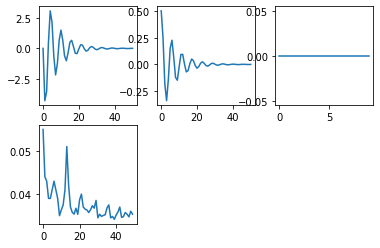

In [35]:
x_complete = np.hstack((x_log))

plt.subplot(2,3,1)
plt.plot(x_complete[0::nx])

plt.subplot(2,3,2)
plt.plot(x_complete[1::nx])

plt.subplot(2,3,3)
plt.plot(u[:])

plt.subplot(2,3,4)
plt.plot(comp_t_log[:])